# Classificação de textos do Twitter com spaCy

## Bibliotecas

In [1]:
# Libs
import re
import string
import random
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
spacy.__version__

'2.2.3'

### Carregando a base de dados

In [2]:
# dados
db = pd.read_csv('../data/Train50.csv', encoding='utf8', sep=';')
db

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, é precisamente o co...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coração do menininho que vc tem. El...,Fri Oct 12 16:28:49 +0000 2018,1,:)
...,...,...,...,...,...
49995,1046762827053232128,:( é tão lindo que dói https://t.co/GqnpgyWWxB,Mon Oct 01 14:04:40 +0000 2018,0,:(
49996,1046762813362966529,"@veraluciarj Pois é.. tenho problema c/ ""coisa...",Mon Oct 01 14:04:37 +0000 2018,0,:(
49997,1046762806392082432,eu te amo tanto minja vidinha meu bem mais pre...,Mon Oct 01 14:04:35 +0000 2018,0,:(
49998,1046762752071618560,@itsLary @jessboluda Pfvor :(,Mon Oct 01 14:04:22 +0000 2018,0,:(


###  pré-processamento dos dados

In [3]:
# eliminando coluna desnecessária
db = db.drop(['id', 'tweet_date', 'query_used'], axis=1)
db.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, é precisamente o co...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coração do menininho que vc tem. El...,1


In [4]:
# informação dos dados
db.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  50000 non-null  object
 1   sentiment   50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


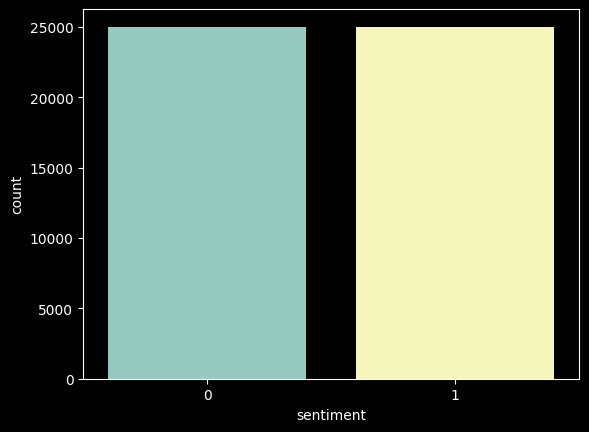

In [5]:
# gráfico de sentimento
sns.countplot(x=db['sentiment'], label='Contagem');

In [6]:
# Verificando valores nulos
db.isnull().sum()

tweet_text    0
sentiment     0
dtype: int64

### Função para pré-processamento dos textos

In [7]:
# Variável para remover pontuações 
pontuacoes = string.punctuation
pontuacoes

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
# Variável para remover as stop_words
from spacy.lang.pt.stop_words import STOP_WORDS

stop_words = STOP_WORDS
len(stop_words)

413

In [9]:
# Carregando o spacy
spacy.prefer_gpu()
pln = spacy.load("pt_core_news_sm")
pln

In [10]:
# Criação da função de processamento 
def preprocessamento(texto):
    # Letras minúsculas
    texto = texto.lower()

    # Nome do usuário
    texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)

    # URLs
    texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

    # Espaços em branco
    texto = re.sub(r" +", ' ', texto)

    # Emoticons
    lista_emocoes = {':)': 'emocaopositiva',
                    ':d': 'emocaopositiva',
                    ':(': 'emocaonegativa'}
    for emocao in lista_emocoes:
        texto = texto.replace(emocao, lista_emocoes[emocao])

    # Lematização
    documento = pln(texto)

    lista = []
    for token in documento:
        lista.append(token.lemma_)
    
    # Stop words e pontuações
    lista = [palavra for palavra in lista if palavra not in stop_words and palavra not in string.punctuation]
    lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
    
    return lista

In [11]:
# testando a função
texto_teste = '@behin_d_curtain :D Para :( mim, http://www.iaexpert.com.br é precisamente o contrário :) Vem a chuva e vem a boa disposição :)'
resultado = preprocessamento(texto_teste)
resultado

'  emocaopositiva parir emocaonegativa mim precisamente o contrário emocaopositiva vir o chuva e vir o disposição emocaopositiva'

In [12]:
# usando 10% da base de dados 
db_train = db.sample(n=5000)
# fazendo o tratamento
db_train['tweet_text'] = db_train['tweet_text'].apply(preprocessamento)
db_train.head(10)

,tweet_text,sentiment
18454,melhor telegram pq vc preciso passar querer ...,1
25800,n querer umar comunidade e trazer amigo gay ...,0
9241,falir emocaopositiva,1
10956,sair beijar deixar kkk emocaopositiva obriga...,1
649,mãe comprar pastel dia criança p mim kkkkkkkk ...,1
10380,o faltar o stb :p,1
14461,passar falar nadica frances rs achar o chave...,1
42892,adiantar ninguém gostar mim emocaonegativa,0
18756,o menino lindo emocaopositiva — ooobg ♥ ️,1
38735,e pensar passar o show d inteirar deixar trist...,0


In [13]:
# transformando a base de dados
db_train_final = []
for texto, emocao in zip(db_train['tweet_text'], db_train['sentiment']):
    if emocao == 1:
        dic = ({'POSITIVO': True, 'NEGATIVO': False})
    elif emocao == 0:
        dic = ({'POSITIVO': False, 'NEGATIVO': True})

    db_train_final.append([texto, dic.copy()])

# Tamanho
len(db_train_final)

5000

In [14]:
# Visualizando alguns registros
db_train_final[:10]

[['  melhor telegram pq vc preciso passar querer emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['  n querer umar comunidade e trazer amigo gay trans negro índio nordestino emocaonegativa',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['  falir emocaopositiva', {'POSITIVO': True, 'NEGATIVO': False}],
 ['  sair beijar deixar kkk emocaopositiva obrigar ♡ q pra q o horar certo chegar q ás vezar pensar n e ficar ah pq manir kkkkkkk pensar q querer atitude e tímido kkkk',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['mãe comprar pastel dia criança p mim kkkkkkkk emocaopositiva',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['o faltar o stb :p', {'POSITIVO': True, 'NEGATIVO': False}],
 ['  passar falar nadica frances rs achar o chave chegar falar inglês caro cumprimentar formalidade e perguntar o pessoa ajudar inglês certar :-)',
  {'POSITIVO': True, 'NEGATIVO': False}],
 ['adiantar ninguém gostar mim emocaonegativa',
  {'POSITIVO': False, 'NEGATIVO': True}],
 ['o menino lindo emocao

### Criação do classificador

In [15]:
# Criação do modelo
modelo = spacy.blank('pt')
categorias = modelo.create_pipe("textcat")
categorias.add_label("POSITIVO")
categorias.add_label("NEGATIVO")
modelo.add_pipe(categorias)
historico = []

In [16]:
# Treinado o modelo
modelo.begin_training()
for epoca in range(30):
    random.shuffle(db_train_final)
    losses = {}
    for batch in spacy.util.minibatch(db_train_final, 512):
        textos = [modelo(texto) for texto, entities in batch]
        annotations = [{'cats': entities} for texto, entities in batch]
        modelo.update(textos, annotations, losses=losses)
        historico.append(losses)
    if epoca % 5 == 0:
        print(losses)

{'textcat': 8.682508337187755e-06}
{'textcat': 9.627524111266439e-09}
{'textcat': 7.924786382673688e-10}
{'textcat': 4.554995165773068e-10}
{'textcat': 3.4222869590289084e-10}
{'textcat': 2.5415355237035087e-10}


In [17]:
# Armazenando os valores dos resultados
historico_loss = []
for i in historico:
    historico_loss.append(i.get('textcat'))

In [18]:
# convertendo para um array
historico_loss = np.array(historico_loss)
historico_loss

array([8.68250834e-06, 8.68250834e-06, 8.68250834e-06, 8.68250834e-06,
       8.68250834e-06, 8.68250834e-06, 8.68250834e-06, 8.68250834e-06,
       8.68250834e-06, 8.68250834e-06, 3.03588581e-07, 3.03588581e-07,
       3.03588581e-07, 3.03588581e-07, 3.03588581e-07, 3.03588581e-07,
       3.03588581e-07, 3.03588581e-07, 3.03588581e-07, 3.03588581e-07,
       8.87120236e-08, 8.87120236e-08, 8.87120236e-08, 8.87120236e-08,
       8.87120236e-08, 8.87120236e-08, 8.87120236e-08, 8.87120236e-08,
       8.87120236e-08, 8.87120236e-08, 5.56173076e-08, 5.56173076e-08,
       5.56173076e-08, 5.56173076e-08, 5.56173076e-08, 5.56173076e-08,
       5.56173076e-08, 5.56173076e-08, 5.56173076e-08, 5.56173076e-08,
       2.37297986e-08, 2.37297986e-08, 2.37297986e-08, 2.37297986e-08,
       2.37297986e-08, 2.37297986e-08, 2.37297986e-08, 2.37297986e-08,
       2.37297986e-08, 2.37297986e-08, 9.62752411e-09, 9.62752411e-09,
       9.62752411e-09, 9.62752411e-09, 9.62752411e-09, 9.62752411e-09,
      

Text(0, 0.5, 'Erro')

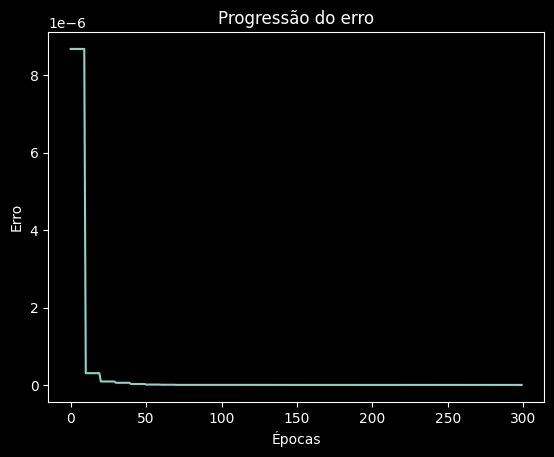

In [19]:
# Visualizando a regressão do erro
import matplotlib.pyplot as plt
plt.plot(historico_loss)
plt.title('Progressão do erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')

In [20]:
# Salvando o modelo
modelo.to_disk('modelo_twt')

### Avaliando com a base de Treinamento

In [21]:
# Carregando o modelo
modelo_carregado = spacy.load('modelo_twt')
modelo_carregado

In [22]:
# Toda a base
previsoes = []
for texto in db_train['tweet_text']:
    previsao = modelo_carregado(texto)
    previsoes.append(previsao.cats)

previsoes


[{'POSITIVO': 0.9999303817749023, 'NEGATIVO': 0.00019191743922419846},
 {'POSITIVO': 0.00013496007886715233, 'NEGATIVO': 0.9991167187690735},
 {'POSITIVO': 0.9999545812606812, 'NEGATIVO': 0.0002071466442430392},
 {'POSITIVO': 0.9999545812606812, 'NEGATIVO': 0.0004008139076177031},
 {'POSITIVO': 0.9999545812606812, 'NEGATIVO': 0.00019377439457457513},
 {'POSITIVO': 0.9995087385177612, 'NEGATIVO': 0.00036762809031642973},
 {'POSITIVO': 0.9999014139175415, 'NEGATIVO': 0.0002500453556422144},
 {'POSITIVO': 0.00021753487817477435, 'NEGATIVO': 0.9995527863502502},
 {'POSITIVO': 0.9999545812606812, 'NEGATIVO': 0.0006195548339746892},
 {'POSITIVO': 0.0002274478756589815, 'NEGATIVO': 0.9996572732925415},
 {'POSITIVO': 0.9999533891677856, 'NEGATIVO': 5.220619641477242e-05},
 {'POSITIVO': 0.9999545812606812, 'NEGATIVO': 0.00036392558831721544},
 {'POSITIVO': 0.00022448568779509515, 'NEGATIVO': 0.9996528625488281},
 {'POSITIVO': 0.9997337460517883, 'NEGATIVO': 0.0004107092972844839},
 {'POSITIVO':

In [23]:
# Convertendo para array
previsoes_final = []
for previsao in previsoes:
    if previsao['POSITIVO'] > previsao['NEGATIVO']:
        previsoes_final.append(1)
    else:
        previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [24]:
# armazenado o valor  a base de dados
respostas_reais = db_train['sentiment'].values
respostas_reais

array([1, 0, 1, ..., 1, 0, 1], dtype=int64)

In [25]:
# Visualizando a taxa de acerto 
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(respostas_reais, previsoes_final)

1.0

In [26]:
# Matrix de confusão
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

array([[2509,    0],
       [   0, 2491]], dtype=int64)

### Testando com a base de teste

In [27]:
# dados de teste
db_test = pd.read_csv('../data/Test.csv', encoding='utf8', sep=';')
db_test

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,Estávamos em casa do Zé e eu estava a morrer d...,Wed Aug 15 01:13:49 +0000 2018,1,:)
...,...,...,...,...,...
4995,1030528364145201153,@ol_cdanilo parece livro de autoajuda :(,Fri Aug 17 18:54:42 +0000 2018,0,:(
4996,1030528418235015168,@tatazoquita aaaaa sinto muito :((,Fri Aug 17 18:54:55 +0000 2018,0,:(
4997,1030528446122930176,To começando a sentir dor de novo e meu irmão ...,Fri Aug 17 18:55:02 +0000 2018,0,:(
4998,1030528453752352769,@ichbintw parece que no dia que toma a vacina ...,Fri Aug 17 18:55:04 +0000 2018,0,:(


### Pré-processamento

In [28]:
# eliminado colunas 
db_test = db_test.drop(['id', 'tweet_date', 'query_used'], axis=1)
db_test

,tweet_text,sentiment
0,@Gazo1a Nossa! Muito obrigada :),1
1,@BerzGamer vai pa puta que te pariu :),1
2,QUER MAIS DESCONTOS? (14/08) ⭐⭐⭐⭐⭐ 🌐 Confira n...,1
3,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",1
4,Estávamos em casa do Zé e eu estava a morrer d...,1
...,...,...
4995,@ol_cdanilo parece livro de autoajuda :(,0
4996,@tatazoquita aaaaa sinto muito :((,0
4997,To começando a sentir dor de novo e meu irmão ...,0
4998,@ichbintw parece que no dia que toma a vacina ...,0


In [29]:
# Pre-processamento
db_test['tweet_text'] = db_test['tweet_text'].apply(preprocessamento)
db_test.head()

,tweet_text,sentiment
0,obrigar emocaopositiva,1
1,pa puta parir emocaopositiva,1
2,querer desconto 14/08 ⭐ ⭐ ⭐ ⭐ ⭐ 🌐 conferir o l...,1
3,vcs ajudar galera pelar amor butera emocaoposi...,1
4,casar zé e o morrer sono chegar o casar e fica...,1


In [30]:
# prevendo Toda a base
previsoes = []
for texto in db_test['tweet_text']:
    previsao = modelo_carregado(texto)
    previsoes.append(previsao.cats)

previsoes

[{'POSITIVO': 0.9998843669891357, 'NEGATIVO': 0.00017026516434270889},
 {'POSITIVO': 0.9999545812606812, 'NEGATIVO': 0.00010772867972264066},
 {'POSITIVO': 0.9992184638977051, 'NEGATIVO': 0.00012309971498325467},
 {'POSITIVO': 0.9997406601905823, 'NEGATIVO': 0.00016899901675060391},
 {'POSITIVO': 0.9999294281005859, 'NEGATIVO': 0.0002817999629769474},
 {'POSITIVO': 0.9999545812606812, 'NEGATIVO': 0.00019294842786621302},
 {'POSITIVO': 0.9998774528503418, 'NEGATIVO': 7.434841973008588e-05},
 {'POSITIVO': 0.9999545812606812, 'NEGATIVO': 0.00019986230472568423},
 {'POSITIVO': 0.999342143535614, 'NEGATIVO': 0.0008747176034376025},
 {'POSITIVO': 0.9998524188995361, 'NEGATIVO': 0.0004996283678337932},
 {'POSITIVO': 0.9999545812606812, 'NEGATIVO': 0.00023348820104729384},
 {'POSITIVO': 0.9996908903121948, 'NEGATIVO': 0.00023486089776270092},
 {'POSITIVO': 0.9999545812606812, 'NEGATIVO': 0.00015319997328333557},
 {'POSITIVO': 0.9998984336853027, 'NEGATIVO': 0.0002457276568748057},
 {'POSITIVO'

In [31]:
# Convertendo para array
previsoes_final = []
for previsao in previsoes:
    if previsao['POSITIVO'] > previsao['NEGATIVO']:
        previsoes_final.append(1)
    else:
        previsoes_final.append(0)

previsoes_final = np.array(previsoes_final)

In [32]:
# Convertendo e visualizando a taxa de acerto
respostas_reais = db_test['tweet_text'].values
accuracy_score(respostas_reais, previsoes_final)

0.0

In [33]:
# Matriz de Confusão
cm = confusion_matrix(respostas_reais, previsoes_final)
cm

ValueError: Mix of label input types (string and number)